In [1]:
import os
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import gmean

In [2]:
base_dir = "../logs/GAP/"
# Define trace names and configuration labels
trace_names = ['bc-5', 'bfs-8', 'cc-5', 'pr-5', 'sssp-5']
configs = ['baseline', 'ipcp', 'ipcp-isb','isb-degree-8']

# Initialize a dictionary to store IPC values for each trace and configuration
ipc_values = {trace: {} for trace in trace_names}


In [3]:
ipc_values

{'bc-5': {}, 'bfs-8': {}, 'cc-5': {}, 'pr-5': {}, 'sssp-5': {}}

In [4]:
def extract_ipc(log_file):
    with open(log_file, 'r') as f:
        for line in f:
            if 'CPU 0 cumulative IPC' in line:  # Assuming the line with IPC contains the keyword 'IPC'
                ipc_value = float(re.search(r"IPC:\s([\d\.]+)", line).group(1))
                return ipc_value
    return None

# Parse the IPC values from the log files
for trace in trace_names:
    for config in configs:
        log_file = base_dir + f"{trace}-{config}.log"
        ipc_values[trace][config] = extract_ipc(log_file)


In [5]:
# Calculate speedups relative to the baseline
speedups = {trace: {} for trace in trace_names}

for trace in trace_names:
    baseline_ipc = ipc_values[trace]['baseline']
    for config in configs[1:]:  # Skip baseline
        speedups[trace][config] = ipc_values[trace][config] / baseline_ipc

# Calculate geometric mean for each configuration (excluding baseline)
geomeans = {}
for config in configs[1:]:
    config_speedups = [speedups[trace][config] for trace in trace_names]
    geomeans[config] = gmean(config_speedups)  # Use scipy's gmean for geometric mean

speedups['Geomean'] = geomeans
trace_names += ['Geomean']
speedups

{'bc-5': {'ipcp': 0.9239578294159841,
  'ipcp-isb': 0.8775334879143243,
  'isb-degree-8': 0.9093198992443324},
 'bfs-8': {'ipcp': 1.4793817872454,
  'ipcp-isb': 1.4060545148214254,
  'isb-degree-8': 1.4363395999799822},
 'cc-5': {'ipcp': 1.121445084838053,
  'ipcp-isb': 1.0542391339458346,
  'isb-degree-8': 0.990655585652517},
 'pr-5': {'ipcp': 0.9437496092701351,
  'ipcp-isb': 0.9511909446285217,
  'isb-degree-8': 0.9880740051557955},
 'sssp-5': {'ipcp': 1.2019596150112333,
  'ipcp-isb': 1.1417739161789588,
  'isb-degree-8': 1.0131819820819348},
 'Geomean': {'ipcp': np.float64(1.116995486017075),
  'ipcp-isb': np.float64(1.0715453677060092),
  'isb-degree-8': np.float64(1.0531123133409752)}}

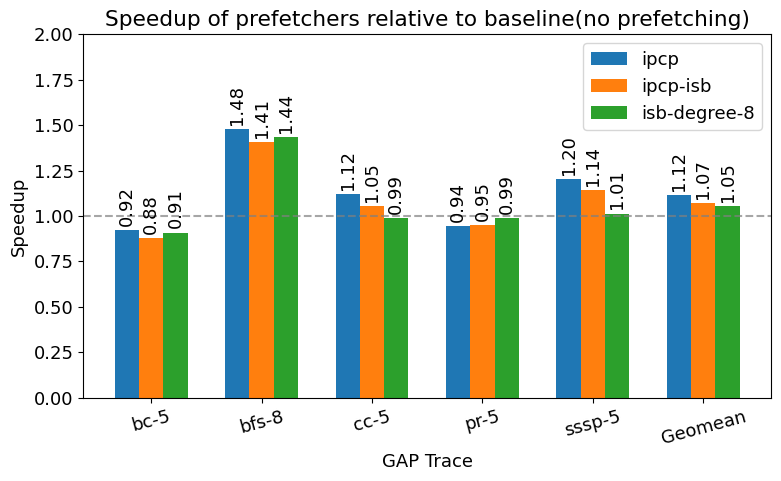

In [18]:
# Plotting the speedups
plt.rcParams.update({'font.size': 13})
x = np.arange(len(trace_names))  # X axis positions for the traces
width = 0.22  # Width of the bars

fig, ax = plt.subplots(figsize=(8, 5))

# Plot bars for each configuration
for i, config in enumerate(configs[1:]):  # Skip baseline
    speedup_values = [speedups[trace][config] for trace in trace_names]
    bars = ax.bar(x + i*width, speedup_values, width, label=config)
    
    # Annotate bars with speedup values
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',  # Format the annotation to 2 decimal places
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text slightly above the bar
                    textcoords="offset points",
                    ha='center', va='bottom',rotation=90)

# Add a translucent dashed line at y=1.0 for the baseline
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)


# Add labels and titles
ax.set_xlabel('GAP Trace')
ax.set_ylabel('Speedup')
ax.set_ylim(0, 2.0)
ax.set_title('Speedup of prefetchers relative to baseline(no prefetching)')
ax.set_xticks(x + 2*width / 2)
ax.set_xticklabels(trace_names, rotation=15)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
